# Loading Libraries

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# other
import string
import math
import missingno as msno

# data viz
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# from autoviz.AutoViz_Class import AutoViz_Class
# %matplotlib inline
import plotly.express as px
%matplotlib inline

# sklearn - other
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# sklearn - ML models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# lightgbm
import lightgbm as lgbm

# xgboost
import xgboost as xgb

# catboost
import catboost as cb

# Reading the datasets

In [2]:
songs_df = pd.read_csv("../input/wsdm-music-recommendation/songs.csv")
songs_extra_df = pd.read_csv("../input/wsdm-music-recommendation/song_extra_info.csv")
members_df = pd.read_csv("../input/wsdm-music-recommendation/members.csv")
train_df = pd.read_csv("../input/wsdm-music-recommendation/train.csv", nrows = 100000)
t_s = pd.merge(train_df, songs_df, on='song_id', how='left')
t_s_se = pd.merge(t_s, songs_extra_df, on='song_id', how='left')
songs = pd.merge(t_s_se, members_df, on='msno', how='left')
del songs_df, songs_extra_df, members_df, train_df, t_s, t_s_se
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

# Dealing with the missing values

<AxesSubplot:>

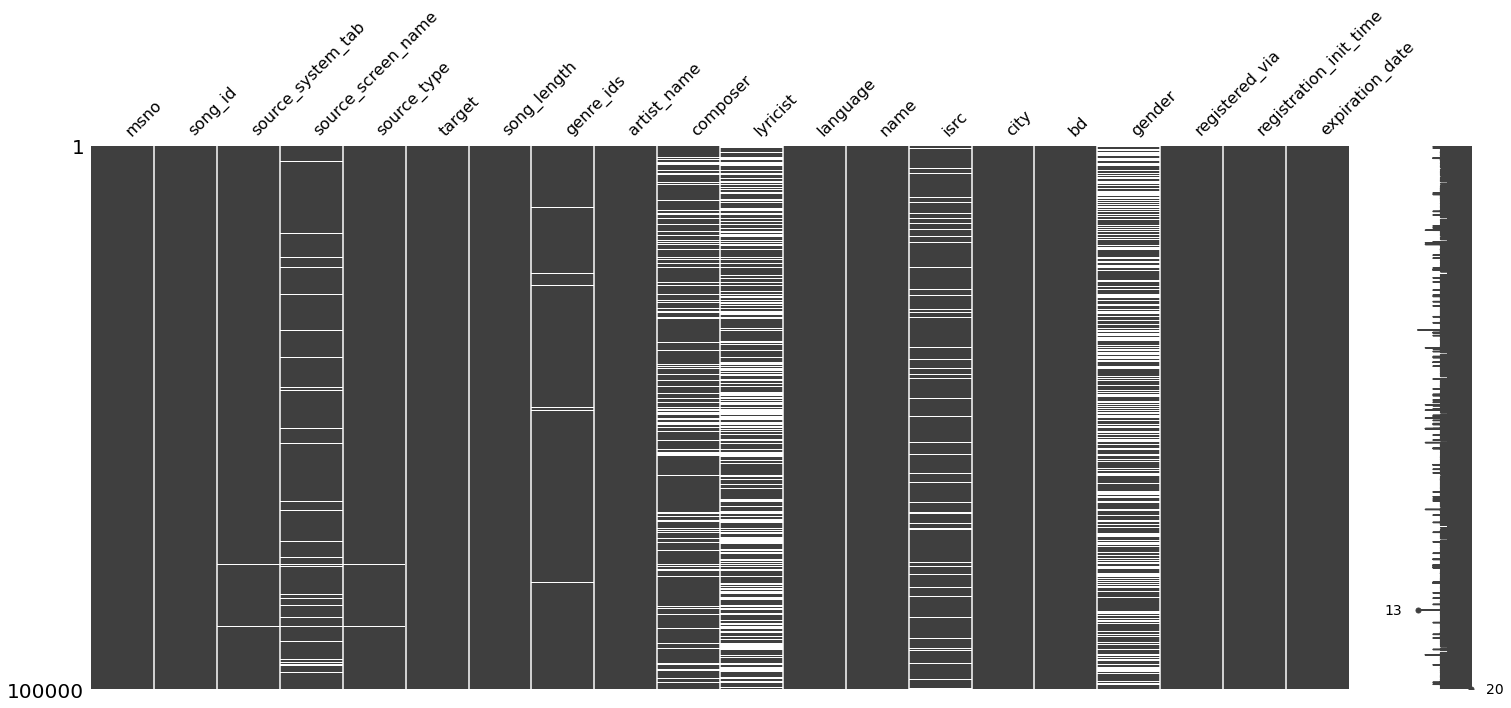

In [4]:
msno.matrix(songs)

In [5]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

# songs.dropna(inplace=True)

# Extracting new features

In [6]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [7]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [8]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

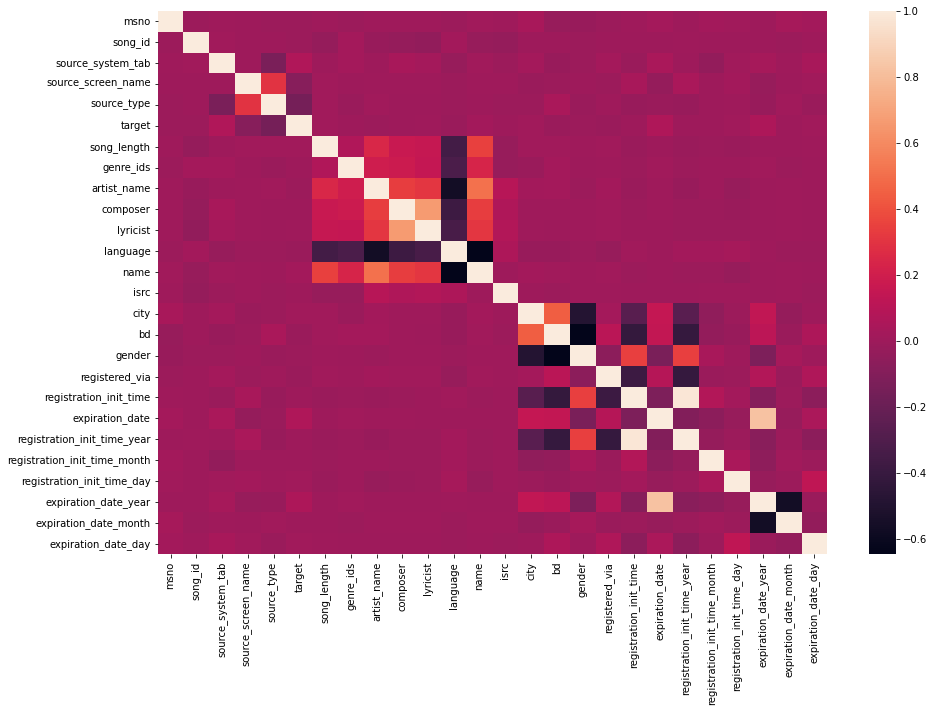

In [9]:
# Сorrelation matrix
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr())
plt.show()

# Modeling

In [10]:
X = songs.drop('target', axis = 1)
y = songs.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [11]:
def model_with(model_name, X_train, X_test, y_train, y_test) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier()
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier()
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier()
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier()
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(verbose=0)
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print()
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("ROC :", roc_auc_score(y_test, y_pred))
    
    print("==================================================")
    print()

In [12]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier", "CatBoost Classifier"]
for i in models :
    model_with(i, X_train, X_test, y_train, y_test)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.75      0.58      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.76      0.78     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.84852
ROC : 0.7574349056105204

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      6176
           1       0.88      0.93      0.90     18824

    accuracy                           0.84     25000
   macro avg       0.80      0.76      0.78     25000
weighted avg       0.84      0.84      0.84     25000


Accuracy : 0.84496
ROC : 0.7616529045161177

Modeling with : LightGBM Classifier

              precision    recall  f1-score   support

           0       0.73      0.40      0.52      6176
           1       0.83   

# Random Forest and class weights

In [13]:
rf = RandomForestClassifier()

#Setting the range for class weights
weights = np.linspace(0.0,1.99,100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:2.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= rf, 
                          param_grid= param_grid,
                          cv=5,
                          scoring='accuracy', 
                          verbose=0).fit(X_train, y_train)

Text(0.5, 1.0, 'Scoring for different class weights')

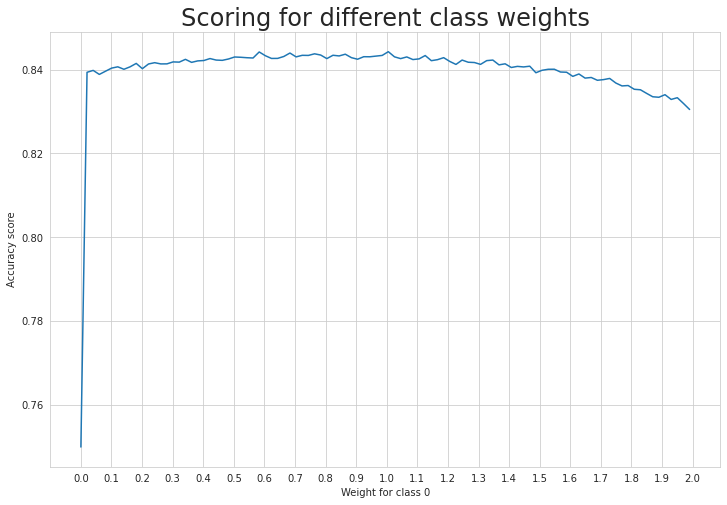

In [14]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 0')
plt.ylabel('Accuracy score')
plt.xticks([round(i/10,1) for i in range(0,21,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [15]:
gridsearch.best_estimator_

RandomForestClassifier(class_weight={0: 1.0050505050505052,
                                     1: 0.9949494949494948})

In [16]:
# Best score we get :
gridsearch.best_score_

0.8443066666666666

### Thanks for checking out the notebook :)